# Project AV

## Fraud Detection System Using Data Visualization and Machine Learning

Norbert Tomàs Escudero (242695) Marc Sirvent Ruiz (240198)


The goal of this project is to build an integrated solution for detecting and preventing fraudulent financial transactions.

Our project focuses on answering the following questions:
- What trends and patterns are evident in transaction data, and how do they relate to fraudulent activity? (difference in trends and patterns from transaction data (non-fraudulent) and fraudulent)  
- Which features (e.g., transaction amount, card type, country) are the most important indicators of fraud? (Using SHAP on our predictive model of fraud) 
- How can we present insights and predictions in a user-friendly manner for decision-making? 

The results of this project will assist stakeholders in identifying fraud patterns through data-driven decisions.

https://www.kaggle.com/datasets/computingvictor/transactions-fraud-datasets?select=train_fraud_labels.json

## Setup and data imports

In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
GLOBAL_PATH = './data/'
USERS_DATASET = "users_data.csv"
CARDS_DATASET = "cards_data.csv"
TRANSACTIONS_DATASET = "transactions_data.csv"
TRAIN_FRAUD_LABELS = "train_fraud_labels.json"
MCC_CODES_DATASET = "mcc_codes.json"

users_df = pd.read_csv(GLOBAL_PATH + USERS_DATASET)
cards_df = pd.read_csv(GLOBAL_PATH + CARDS_DATASET)
transactions_df = pd.read_csv(GLOBAL_PATH + TRANSACTIONS_DATASET)
train_fraud_labels_df = pd.read_json(GLOBAL_PATH + TRAIN_FRAUD_LABELS)
mcc_codes_df = pd.read_json(GLOBAL_PATH + MCC_CODES_DATASET, typ='series')

In [3]:
print("USERS_DATASET")
display(users_df.head())

print("\nCARDS_DATASET")
display(cards_df.head())

print("\nTRANSACTIONS_DATASET")
display(transactions_df.head())

print("\nTRAIN_FRAUD_LABELS")
display(train_fraud_labels_df.head())

print("\nMCC_CODES_DATASET")
display(mcc_codes_df.head())

USERS_DATASET


,id,current_age,retirement_age,birth_year,birth_month,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards
0,825,53,66,1966,11,Female,462 Rose Lane,34.15,-117.76,$29278,$59696,$127613,787,5
1,1746,53,68,1966,12,Female,3606 Federal Boulevard,40.76,-73.74,$37891,$77254,$191349,701,5
2,1718,81,67,1938,11,Female,766 Third Drive,34.02,-117.89,$22681,$33483,$196,698,5
3,708,63,63,1957,1,Female,3 Madison Street,40.71,-73.99,$163145,$249925,$202328,722,4
4,1164,43,70,1976,9,Male,9620 Valley Stream Drive,37.76,-122.44,$53797,$109687,$183855,675,1



CARDS_DATASET


,id,client_id,card_brand,card_type,card_number,expires,cvv,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,card_on_dark_web
0,4524,825,Visa,Debit,4344676511950444,12/2022,623,YES,2,$24295,09/2002,2008,No
1,2731,825,Visa,Debit,4956965974959986,12/2020,393,YES,2,$21968,04/2014,2014,No
2,3701,825,Visa,Debit,4582313478255491,02/2024,719,YES,2,$46414,07/2003,2004,No
3,42,825,Visa,Credit,4879494103069057,08/2024,693,NO,1,$12400,01/2003,2012,No
4,4659,825,Mastercard,Debit (Prepaid),5722874738736011,03/2009,75,YES,1,$28,09/2008,2009,No



TRANSACTIONS_DATASET


,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors
0,7475327,2010-01-01 00:01:00,1556,2972,$-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,5499,NaN
1,7475328,2010-01-01 00:02:00,561,4575,$14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,5311,NaN
2,7475329,2010-01-01 00:02:00,1129,102,$80.00,Swipe Transaction,27092,Vista,CA,92084.0,4829,NaN
3,7475331,2010-01-01 00:05:00,430,2860,$200.00,Swipe Transaction,27092,Crown Point,IN,46307.0,4829,NaN
4,7475332,2010-01-01 00:06:00,848,3915,$46.41,Swipe Transaction,13051,Harwood,MD,20776.0,5813,NaN



TRAIN_FRAUD_LABELS


,target
10649266,No
23410063,No
9316588,No
12478022,No
9558530,No



MCC_CODES_DATASET


5812           Eating Places and Restaurants
5541                        Service Stations
7996    Amusement Parks, Carnivals, Circuses
5411            Grocery Stores, Supermarkets
4784                   Tolls and Bridge Fees
dtype: object

## Data Cleaning

In [4]:
#Auxiliary functions

def remove_dollar(df, columns_to_clean):
    for column in columns_to_clean:
        df[column] = df[column].str.replace(r'[\$,]', '', regex=True)
        df[column] = pd.to_numeric(df[column])
    return df

In [5]:
# Users df
users_df_clean = users_df.copy()
users_df_clean = pd.get_dummies(users_df_clean, columns=['gender'], drop_first=True)
users_df_clean = remove_dollar(users_df_clean, ['per_capita_income', 'yearly_income', 'total_debt'])
users_df_clean = users_df_clean.drop(columns=['address'])

columns_to_rename = {'id': 'user_id'}
users_df_clean.rename(columns=columns_to_rename, inplace=True)

users_df_clean.head()

,user_id,current_age,retirement_age,birth_year,birth_month,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,gender_Male
0,825,53,66,1966,11,34.15,-117.76,29278,59696,127613,787,5,False
1,1746,53,68,1966,12,40.76,-73.74,37891,77254,191349,701,5,False
2,1718,81,67,1938,11,34.02,-117.89,22681,33483,196,698,5,False
3,708,63,63,1957,1,40.71,-73.99,163145,249925,202328,722,4,False
4,1164,43,70,1976,9,37.76,-122.44,53797,109687,183855,675,1,True


In [6]:
# Cards df
cards_df_clean = cards_df.copy()
cards_df_clean = remove_dollar(cards_df_clean, ['credit_limit'])

cards_df_clean['expires'] = pd.to_datetime(cards_df_clean['expires'], format="%m/%Y")
cards_df_clean['acct_open_date'] = pd.to_datetime(cards_df_clean['acct_open_date'], format="%m/%Y")
cards_df_clean['year_pin_last_changed'] = pd.to_datetime(cards_df_clean['year_pin_last_changed'], format="%Y")

cards_df_clean = pd.get_dummies(cards_df_clean, columns=['card_on_dark_web', 'has_chip', 'card_brand', 'card_type'], drop_first=True)

columns_to_rename = {'id': 'card_id', 'client_id': 'user_id', 'expires': 'card_expiration_date'}
cards_df_clean.rename(columns=columns_to_rename, inplace=True)

cards_df_clean.head()

,card_id,user_id,card_number,card_expiration_date,cvv,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,has_chip_YES,card_brand_Discover,card_brand_Mastercard,card_brand_Visa,card_type_Debit,card_type_Debit (Prepaid)
0,4524,825,4344676511950444,2022-12-01,623,2,24295,2002-09-01,2008-01-01,True,False,False,True,True,False
1,2731,825,4956965974959986,2020-12-01,393,2,21968,2014-04-01,2014-01-01,True,False,False,True,True,False
2,3701,825,4582313478255491,2024-02-01,719,2,46414,2003-07-01,2004-01-01,True,False,False,True,True,False
3,42,825,4879494103069057,2024-08-01,693,1,12400,2003-01-01,2012-01-01,False,False,False,True,False,False
4,4659,825,5722874738736011,2009-03-01,75,1,28,2008-09-01,2009-01-01,True,False,True,False,False,True


In [7]:
# Transactions df
transactions_df_clean = transactions_df.copy()

transactions_df_clean = remove_dollar(transactions_df_clean, ['amount'])
transactions_df_clean['date'] = pd.to_datetime(transactions_df_clean['date'], format="%Y-%m-%d %H:%M:%S")
transactions_df_clean = transactions_df_clean.drop(columns=['merchant_city', 'merchant_state', 'zip', 'errors']) # TODO: Dropped this columns because they have a lot of nulls
transactions_df_clean = pd.get_dummies(transactions_df_clean, columns=['use_chip'], drop_first=False)

columns_to_rename = {'id': 'transaction_id', 'date': 'transaction_date', 'client_id': 'user_id', 'amount': 'transaction_amount'}
transactions_df_clean.rename(columns=columns_to_rename, inplace=True)

transactions_df_clean.head()

,transaction_id,transaction_date,user_id,card_id,transaction_amount,merchant_id,mcc,use_chip_Chip Transaction,use_chip_Online Transaction,use_chip_Swipe Transaction
0,7475327,2010-01-01 00:01:00,1556,2972,-77.00,59935,5499,False,False,True
1,7475328,2010-01-01 00:02:00,561,4575,14.57,67570,5311,False,False,True
2,7475329,2010-01-01 00:02:00,1129,102,80.00,27092,4829,False,False,True
3,7475331,2010-01-01 00:05:00,430,2860,200.00,27092,4829,False,False,True
4,7475332,2010-01-01 00:06:00,848,3915,46.41,13051,5813,False,False,True


In [8]:
# Train fraud labels df
train_fraud_labels_df_clean = train_fraud_labels_df.copy()
train_fraud_labels_df_clean = pd.get_dummies(train_fraud_labels_df_clean, columns=['target'], drop_first=True)

train_fraud_labels_df_clean.head()

,target_Yes
10649266,False
23410063,False
9316588,False
12478022,False
9558530,False


In [9]:
# Mcc codes
mcc_codes_df_clean = mcc_codes_df.copy()
mcc_codes_df_clean = mcc_codes_df_clean.reset_index()
mcc_codes_df_clean.columns = ['mcc', 'mcc_description']

mcc_codes_df_clean.head()

,mcc,mcc_description
0,5812,Eating Places and Restaurants
1,5541,Service Stations
2,7996,"Amusement Parks, Carnivals, Circuses"
3,5411,"Grocery Stores, Supermarkets"
4,4784,Tolls and Bridge Fees


In [10]:
# Ready to join the necessary datasets and columns to train, with the train_fraud_labels_df as target.

# Review the data cleaning and modify accordingly

## Training

In [11]:
# Derive new features from existing ones, e.g., time since last transaction, frequency of transactions per card, or average transaction amount over a period.

## Plots and EDA

In [12]:
transactions_with_labels = pd.merge(transactions_df_clean, train_fraud_labels_df_clean, left_on='transaction_id', right_index=True)
transactions_with_labels.head()

,transaction_id,transaction_date,user_id,card_id,transaction_amount,merchant_id,mcc,use_chip_Chip Transaction,use_chip_Online Transaction,use_chip_Swipe Transaction,target_Yes
0,7475327,2010-01-01 00:01:00,1556,2972,-77.00,59935,5499,False,False,True,False
1,7475328,2010-01-01 00:02:00,561,4575,14.57,67570,5311,False,False,True,False
2,7475329,2010-01-01 00:02:00,1129,102,80.00,27092,4829,False,False,True,False
4,7475332,2010-01-01 00:06:00,848,3915,46.41,13051,5813,False,False,True,False
5,7475333,2010-01-01 00:07:00,1807,165,4.81,20519,5942,False,False,True,False


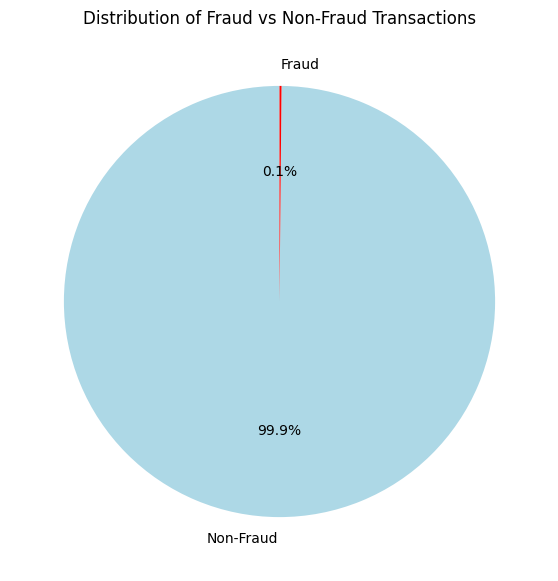

In [13]:
transaction_counts = transactions_with_labels['target_Yes'].value_counts()

plt.figure(figsize=(7,7))
plt.pie(transaction_counts, labels=['Non-Fraud', 'Fraud'], autopct='%1.1f%%', startangle=90, colors=['lightblue', 'red'])
plt.title('Distribution of Fraud vs Non-Fraud Transactions')
plt.show()

In [14]:
transactions_with_labels['target_Yes'].value_counts()

target_Yes
False    8901631
True       13332
Name: count, dtype: int64

The bar charts helps understand the balance between the fraudulent and non-fraudulent transactions. As we can see the dataset is imbalanced, we have a lot non-fraudulent than fraudulent transactions.

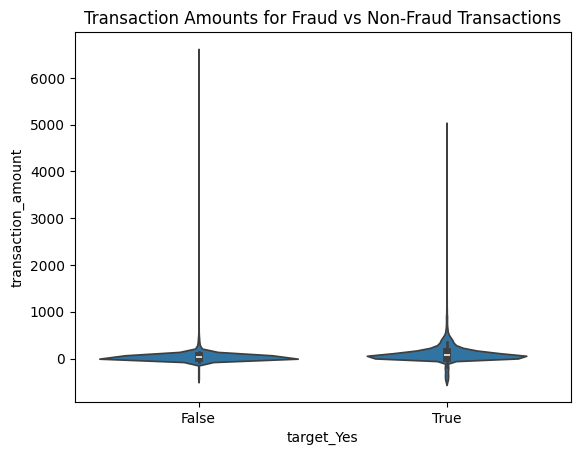

In [15]:
sns.violinplot(x='target_Yes', y='transaction_amount', data=transactions_with_labels)
plt.title('Transaction Amounts for Fraud vs Non-Fraud Transactions')
plt.show()

In [16]:
Q1 = transactions_with_labels['transaction_amount'].quantile(0.25)
Q3 = transactions_with_labels['transaction_amount'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

filtered_transactions = transactions_with_labels[(transactions_with_labels['transaction_amount'] >= lower_bound) & (transactions_with_labels['transaction_amount'] <= upper_bound)]

mean_transaction_amount_by_target = filtered_transactions.groupby('target_Yes')['transaction_amount'].mean()
print(mean_transaction_amount_by_target)

target_Yes
False    36.505369
True     52.609959
Name: transaction_amount, dtype: float64


This plot has the purpose to analyze the spending patterns of fraudulent and non-fraudulent transactions. We can see that in terms of outliers in the spending patterns we cannot extract conclusions. However, if we compute the mean (without outliers) we can see that the transactions that are fraudulent have a higher mean.

In [17]:
transactions_with_labels_mcc = transactions_with_labels.merge(mcc_codes_df_clean, on='mcc', how='left')
transactions_with_labels_mcc.head()

,transaction_id,transaction_date,user_id,card_id,transaction_amount,merchant_id,mcc,use_chip_Chip Transaction,use_chip_Online Transaction,use_chip_Swipe Transaction,target_Yes,mcc_description
0,7475327,2010-01-01 00:01:00,1556,2972,-77.00,59935,5499,False,False,True,False,Miscellaneous Food Stores
1,7475328,2010-01-01 00:02:00,561,4575,14.57,67570,5311,False,False,True,False,Department Stores
2,7475329,2010-01-01 00:02:00,1129,102,80.00,27092,4829,False,False,True,False,Money Transfer
3,7475332,2010-01-01 00:06:00,848,3915,46.41,13051,5813,False,False,True,False,Drinking Places (Alcoholic Beverages)
4,7475333,2010-01-01 00:07:00,1807,165,4.81,20519,5942,False,False,True,False,Book Stores


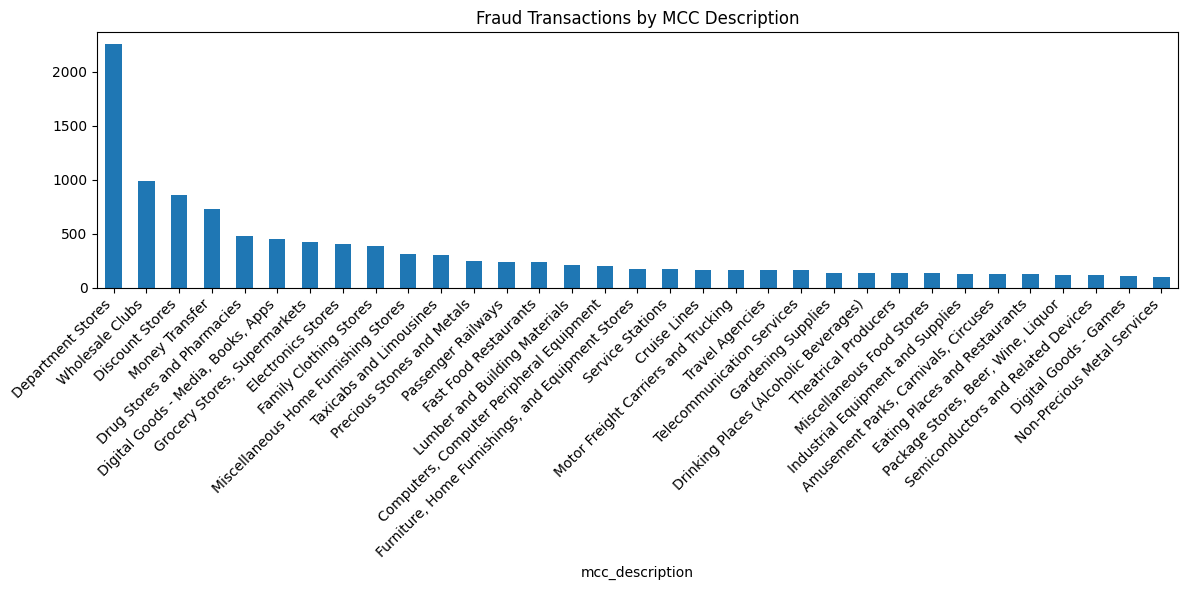

In [18]:
fraud_by_region = transactions_with_labels_mcc[transactions_with_labels_mcc['target_Yes'] == 1] \
    .groupby('mcc_description')['target_Yes'].count() \
    .sort_values(ascending=False)

min_fraud_threshold = 100
fraud_by_region_filtered = fraud_by_region[fraud_by_region >= min_fraud_threshold]

plt.figure(figsize=(12, 6))
fraud_by_region_filtered.plot(kind='bar')
plt.xticks(rotation=45, ha='right')
plt.title('Fraud Transactions by MCC Description')
plt.tight_layout() 
plt.show()

In the graph above we can see the number of fraud (>100 frauds commited) classified by type of bussiness. We can see that the most typical fraud bussiness place are Department Stores.

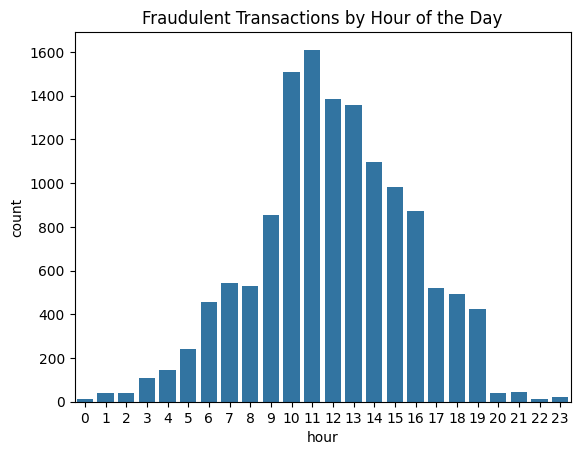

In [19]:
fraud_transactions = transactions_with_labels[transactions_with_labels['target_Yes'] == 1].copy()
fraud_transactions['hour'] = fraud_transactions['transaction_date'].dt.hour

sns.countplot(x='hour', data=fraud_transactions)
plt.title('Fraudulent Transactions by Hour of the Day')
plt.show()

In the plot above we can see that the hour that most fraudulent transactions take place is between 10 and 13.

In [20]:
correlation_df = transactions_with_labels.merge(users_df_clean, on='user_id', how='left')
correlation_df = correlation_df.merge(cards_df_clean, on='card_id', how='left')
correlation_df = correlation_df.drop(columns=['transaction_id', 'user_id_x', 'user_id_y', 'card_id', 'birth_year', 'birth_month', 'latitude', 'longitude'])

correlation_df.head()

,transaction_date,transaction_amount,merchant_id,mcc,use_chip_Chip Transaction,use_chip_Online Transaction,use_chip_Swipe Transaction,target_Yes,current_age,retirement_age,...,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,has_chip_YES,card_brand_Discover,card_brand_Mastercard,card_brand_Visa,card_type_Debit,card_type_Debit (Prepaid)
0,2010-01-01 00:01:00,-77.00,59935,5499,False,False,True,False,30,67,...,2,55,2008-05-01,2008-01-01,True,False,True,False,False,True
1,2010-01-01 00:02:00,14.57,67570,5311,False,False,True,False,48,67,...,1,9100,2005-09-01,2015-01-01,True,False,True,False,False,False
2,2010-01-01 00:02:00,80.00,27092,4829,False,False,True,False,49,65,...,1,14802,2006-01-01,2008-01-01,True,False,True,False,True,False
3,2010-01-01 00:06:00,46.41,13051,5813,False,False,True,False,51,69,...,1,19113,2009-07-01,2014-01-01,True,False,False,True,True,False
4,2010-01-01 00:07:00,4.81,20519,5942,False,False,True,False,47,65,...,1,89,2008-01-01,2015-01-01,True,False,True,False,False,True


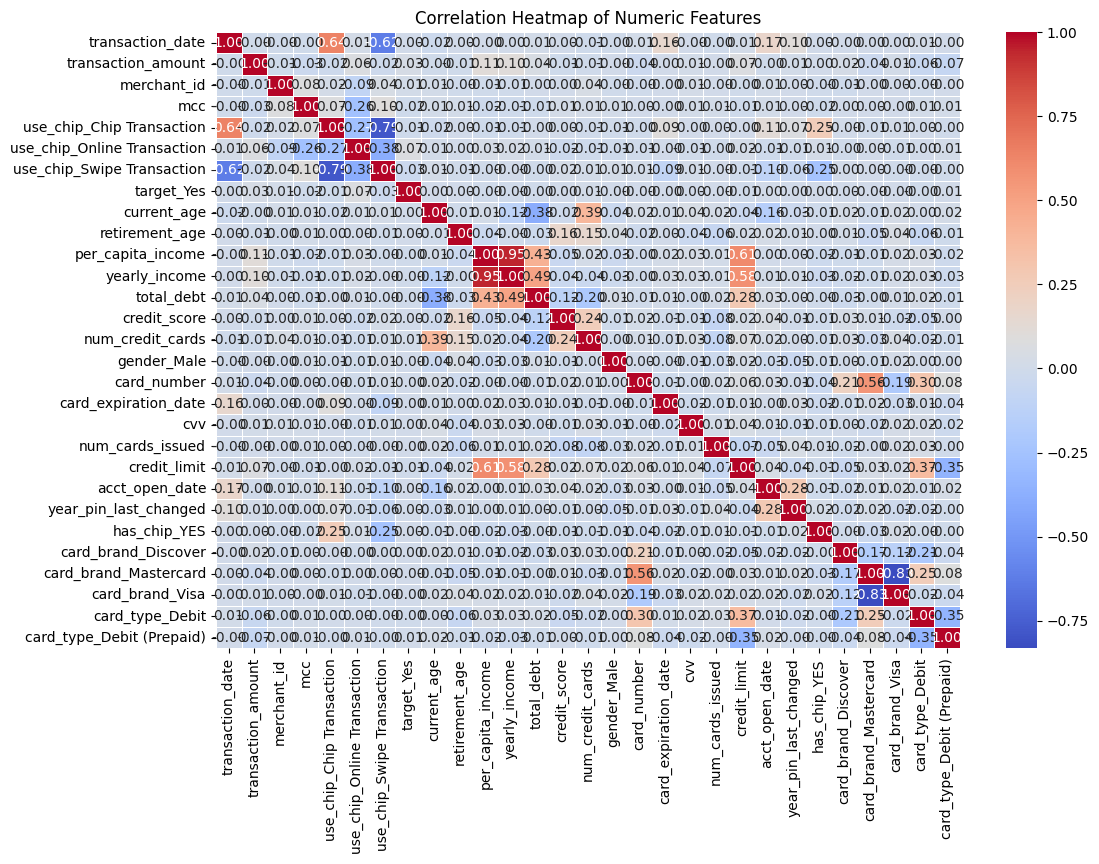

In [21]:
corr = correlation_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Numeric Features')
plt.show()

# TODO: IMPROVE

TODO: IMPROVE

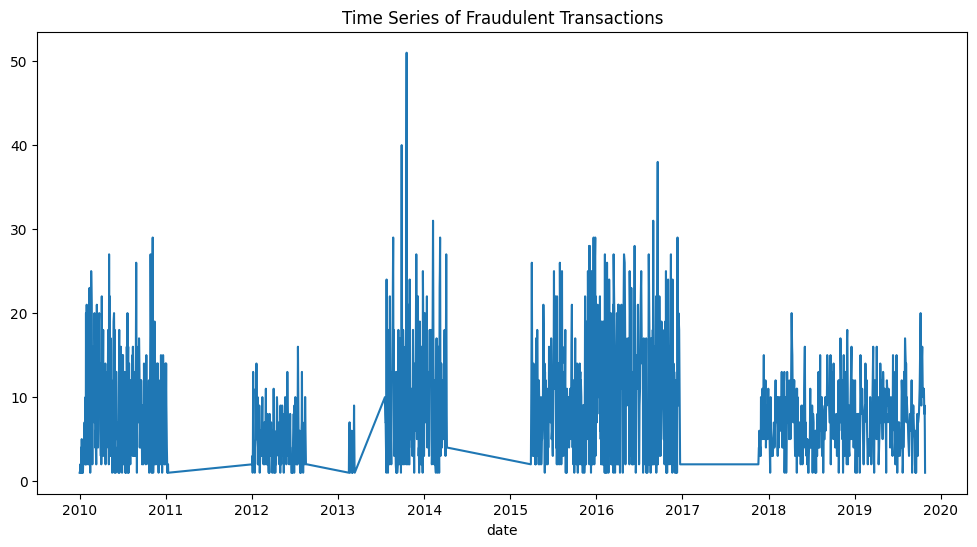

In [22]:
transactions_with_labels['date'] = transactions_with_labels['transaction_date'].dt.date
fraud_trend = transactions_with_labels[transactions_with_labels['target_Yes'] == 1].groupby('date').size()
fraud_trend.plot(kind='line', figsize=(12, 6))
plt.title('Time Series of Fraudulent Transactions')
plt.show()

# TODO: IMPROVE

TODO: IMPROVE

In [23]:
""" import folium

fraud_transactions = transactions_with_labels[transactions_with_labels['target_Yes'] == 1]

# Create a base map centered around the average coordinates
# Adjust latitude and longitude to match your data's center
map_center = [fraud_transactions['latitude'].mean(), fraud_transactions['longitude'].mean()]
m = folium.Map(location=map_center, zoom_start=10)

# Add markers for each fraud transaction
for index, row in fraud_transactions.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,  # Size of the marker
        color='red',  # Color of the marker
        fill=True,
        fill_color='red',
        fill_opacity=0.6
    ).add_to(m)

# Display the map
m.save('fraud_transactions_map.html')  # Save the map to an HTML file """

" import folium\n\nfraud_transactions = transactions_with_labels[transactions_with_labels['target_Yes'] == 1]\n\n# Create a base map centered around the average coordinates\n# Adjust latitude and longitude to match your data's center\nmap_center = [fraud_transactions['latitude'].mean(), fraud_transactions['longitude'].mean()]\nm = folium.Map(location=map_center, zoom_start=10)\n\n# Add markers for each fraud transaction\nfor index, row in fraud_transactions.iterrows():\n    folium.CircleMarker(\n        location=[row['latitude'], row['longitude']],\n        radius=5,  # Size of the marker\n        color='red',  # Color of the marker\n        fill=True,\n        fill_color='red',\n        fill_opacity=0.6\n    ).add_to(m)\n\n# Display the map\nm.save('fraud_transactions_map.html')  # Save the map to an HTML file "